In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneOut
import numpy as np
import copy
import sklearn
from scipy import stats, integrate
from tqdm import tqdm

from distance_functions import c_dist, overlap_area, kl_dist

from evaluation_metrics import get_file_and_dirnames, get_token_flags, pitch_class_transition_matrix, note_length_transition_matrix
from evaluation_metrics import get_metrics_for_multiple_sequences, summarize_evaluation_sequences

PATH_VOCAB = "../0_data/5_vocabs"
PATH_DATA = "../0_data/6_word_data"
PATH_MODELS = "../0_data/7_models"
PATH_MODELS_CONFIG = "../0_data/7_models/config"
PATH_PRED = "../0_data/8_predictions"
PATH_TOKENS = "../0_data/8_predictions/tokens"
PATH_MIDI = "../0_data/8_predictions/midi"

In [3]:
vocab_configs = {
    "a1" : {
        "pitch_range": 128,
        "duration_steps": 64,
        "triole_tokens": False,
        "key": "all",
    },
    "a2" : {
        "pitch_range": 128,
        "duration_steps": 64,
        "triole_tokens": True,
        "key": "all",
    },
    "a3" : {
        "pitch_range": 128,
        "duration_steps": 32,
        "triole_tokens": False,
        "key": "all",
    },
    "b" : {
        "pitch_range": 128,
        "duration_steps": 64,
        "triole_tokens": False,
        "key": "C",
    },
    "c" : {
        "pitch_range": 36,
        "duration_steps": 64,
        "triole_tokens": False,
        "key": "all",
    },
    "d" : {
        "pitch_range": 36,
        "duration_steps": 32,
        "triole_tokens": True,
        "key": "C",
    }
}

In [4]:
seq_metrics_dic = {}

# compute metrics for original data
for key in vocab_configs.keys():
    
    path = f"{PATH_DATA}/{key}_token_data.json"
    with open(path, "r") as fp:
        tokens = json.load(fp)
    token_data = [tokens[key] for key in tokens.keys()]

    token_flags = get_token_flags(vocab_configs[key])
    seq_metrics = get_metrics_for_multiple_sequences(token_data, token_flags)
    seq_metrics_dic[f"{key}_original"] = seq_metrics

# compute metrics for generated data hyperparameter models
model_df = pd.read_excel(f"{PATH_MODELS}/model_stats.xlsx", index_col="Unnamed: 0")
for index, row in model_df.iterrows():

    if row["ran"] == "no" or row["runtime"] == "too big - cuda error":
        continue

    model_name = row["name"]
    with open(f"{PATH_TOKENS}/{model_name}.json", "r") as fp:
        tokens = json.load(fp)
    token_data = tokens["data"]

    token_flags = get_token_flags(vocab_configs["d"])
    seq_metrics = get_metrics_for_multiple_sequences(token_data, token_flags)
    seq_metrics_dic[model_name] = seq_metrics

# compute metrics for generated data abcd models
comp_model_df = pd.read_excel(f"{PATH_MODELS}/comparison_model_stats.xlsx", index_col="Unnamed: 0")
for index, row in comp_model_df.iterrows():

    if row["ran"] == "no" or row["runtime"] == "too big - cuda error":
        continue

    model_name = row["name"]
    with open(f"{PATH_TOKENS}/{model_name}.json", "r") as fp:
        tokens = json.load(fp)
    token_data = tokens["data"]

    token_flags = get_token_flags(vocab_configs[model_name])
    seq_metrics = get_metrics_for_multiple_sequences(token_data, token_flags)
    seq_metrics_dic[f"{model_name}_generated"] = seq_metrics

In [5]:
scalar_metrics = [
    "mean_pitch",
    "pitch_count_seq", 
    "pitch_count_bar",
    "pitch_range_seq",
    "pitch_range_bar",
    "pitch_intervals_avg",
    "pitch_intervals_avg_abs",
    "crooked_pitch_count",
    "note_count_seq",
    "note_count_bar",
    "onset_intervals_avg",
    "mean_duration",
]

hist_metrics = [
    "pitch_intervals_hist",
    "pitch_class_hist_numbers",
    #"pitch_class_hist_pitches",
    "onset_intervals_hist",
    "note_length_hist_numbers",
    #"note_length_hist_bins"
]

matrix_metrics = [
    "pitch_class_transition_matrix",
    "note_length_transition_matrix"
]

metrics_list = scalar_metrics + hist_metrics + matrix_metrics



In [6]:
def get_distances(set_1, set_2, metrics):
    num_samples_1 = len(set_1[metrics[0]])
    num_samples_2 = len(set_2[metrics[0]])

    loo = LeaveOneOut()
    set1_intra = np.zeros((num_samples_1, len(metrics), num_samples_1 - 1))
    set2_intra = np.zeros((num_samples_2, len(metrics), num_samples_2 - 1))
    sets_inter_1_to_2 = np.zeros((num_samples_1, len(metrics), num_samples_2))

    # calculate intra-set distances
    for i, metric in enumerate(metrics):
        for train_index, test_index in loo.split(np.arange(num_samples_1)):
            set1_test_sample = set_1[metric][test_index[0]]
            set1_train_samples = [set_1[metric][index] for index in train_index]
            set1_intra[test_index[0]][i] = c_dist(
                set1_test_sample, set1_train_samples)
            
        for train_index, test_index in loo.split(np.arange(num_samples_2)):
            set2_test_sample = set_2[metric][test_index[0]]
            set2_train_samples = [set_2[metric][index] for index in train_index]
            set2_intra[test_index[0]][i] = c_dist(
                set2_test_sample, set2_train_samples)
            
    # calculate inter-set distances
    for i, metric in enumerate(metrics):
        try:
            for train_index, test_index in loo.split(np.arange(num_samples_1)):
                sets_inter_1_to_2[test_index[0]][i] = c_dist(set_1[metric][test_index[0]], set_2[metric])
        except ValueError:
            print(f"ValueError for {metric}")

    plot_set1_intra = np.transpose(
        set1_intra, (1, 0, 2)).reshape(len(metrics), -1)
    plot_set2_intra = np.transpose(
        set2_intra, (1, 0, 2)).reshape(len(metrics), -1)
    plot_sets_inter = np.transpose(
        sets_inter_1_to_2, (1, 0, 2)).reshape(len(metrics), -1)
    
    return plot_set1_intra, plot_set2_intra, plot_sets_inter


def get_kl_oa_metrics(set_1, set_2, metrics, plot_set1_intra, plot_set2_intra, plot_sets_inter):
    output = {}
    for i in tqdm(range(len(metrics))):
        
        mean1 = np.mean(set_1[metrics[i]], axis=0).tolist()
        std1 = np.std(set_1[metrics[i]], axis=0).tolist()
        mean2 = np.mean(set_2[metrics[i]], axis=0).tolist()
        std2 = np.std(set_2[metrics[i]], axis=0).tolist()
        try:
            kl1 = kl_dist(plot_set1_intra[i], plot_sets_inter[i])
            ol1 = overlap_area(plot_set1_intra[i], plot_sets_inter[i])
            kl2 = kl_dist(plot_set2_intra[i], plot_sets_inter[i])
            ol2 = overlap_area(plot_set2_intra[i], plot_sets_inter[i])
        except:
            kl1, ol1, kl2, ol2 = "error", "error", "error", "error"

        output[metrics[i]] = {
            "mean_set1": mean1,
            "std_set1": std1,
            "mean_set2": mean2,
            "std_set2": std2,
            "kl_set1_inter": kl1,
            "ol_set1_inter": ol1,
            "kl_set2_inter": kl2,
            "ol_set2_inter": ol2
        }
        
    return output

In [7]:
set1_eval = {key: seq_metrics_dic["a1_original"][key] for key in metrics_list}
set2_eval = {key: seq_metrics_dic["d_generated"][key] for key in metrics_list}

#output = get_metric_distances(set1_eval, set2_eval, metrics_list)

In [8]:
set1_intra, set2_intra, sets_inter = get_distances(set1_eval, set2_eval, metrics_list)

ValueError for pitch_intervals_hist
ValueError for note_length_transition_matrix


In [9]:
set2_intra.shape

(18, 9900)

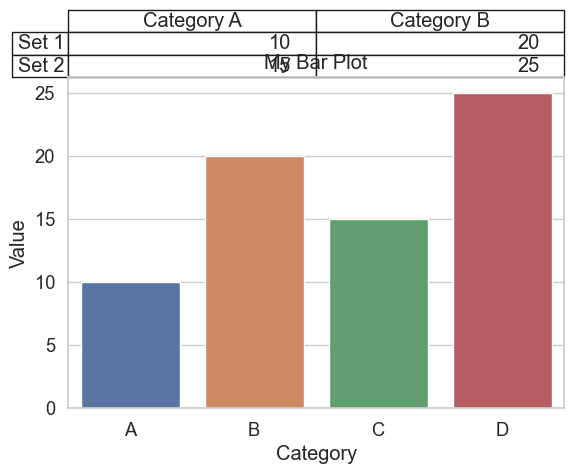

In [42]:


# Create the plot
ax = sns.barplot(x='category', y='value', data=data)

# Add the labels
ax.set(xlabel='Category', ylabel='Value', title='My Bar Plot')

# Add a table with extra values
cell_text = [[10, 20], [15, 25]]
row_labels = ['Set 1', 'Set 2']
col_labels = ['Category A', 'Category B']
table = ax.table(cellText=cell_text, rowLabels=row_labels, colLabels=col_labels, loc='top')

# Adjust the size of the table and plot
table.scale(1, 1.5)
plt.subplots_adjust(top=0.8)

# Show the plot
plt.show()

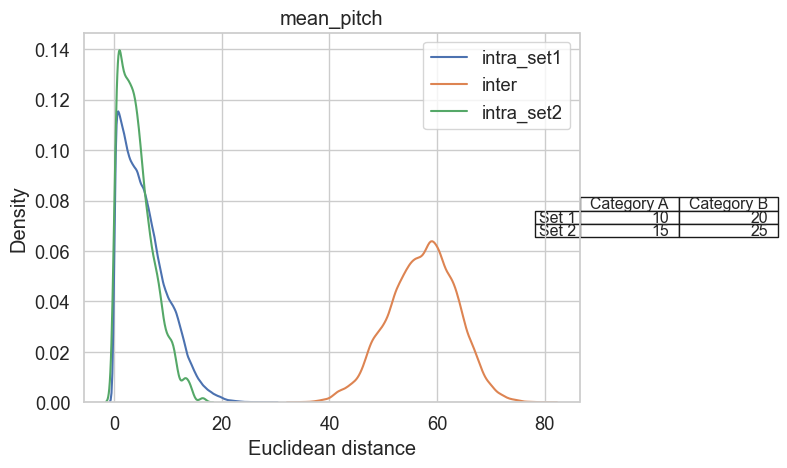

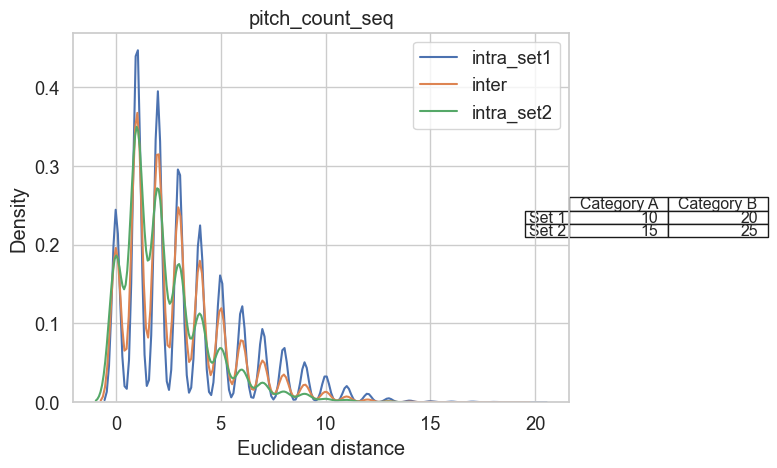

In [58]:
#for i in range(0,len(metrics_list)):
for i in range(0, 2):
    ax = sns.kdeplot(set1_intra[i], label='intra_set1')
    sns.kdeplot(sets_inter[i], label='inter')
    sns.kdeplot(set2_intra[i], label='intra_set2')

    cell_text = [[10, 20], [15, 25]]
    row_labels = ['Set 1', 'Set 2']
    col_labels = ['Category A', 'Category B']
    table = ax.table(cellText=cell_text, rowLabels=row_labels, colLabels=col_labels, loc="right")

    # Adjust the size of the table and plot
    table.scale(0.4, 0.8)
    #plt.subplots_adjust(right=3.8)

    plt.legend()
    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

In [12]:
out = get_kl_oa_metrics(set1_eval, set2_eval, metrics_list, set1_intra, set2_intra, sets_inter)

  6%|▌         | 1/18 [00:10<03:02, 10.71s/it]/Users/julialauten/DataspellProjects/MusicAI/4_evaluation/distance_functions.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda x: min(pdf_A(x), pdf_B(x)), np.min((np.min(A), np.min(B))), np.max((np.max(A), np.max(B))))[0]
100%|██████████| 18/18 [07:56<00:00, 26.49s/it]


In [13]:
out

{'mean_pitch': {'mean_set1': 72.46045454545455,
  'std_set1': 5.004673947753431,
  'mean_set2': 15.1807,
  'std_set2': 3.7760204594255047,
  'kl_set1_inter': 2.6834164122225124,
  'ol_set1_inter': 8.774265101496804e-16,
  'kl_set2_inter': 1.8075496522653163,
  'ol_set2_inter': 6.220671456525933e-69},
 'pitch_count_seq': {'mean_set1': 11.446784922394679,
  'std_set1': 2.997956746217249,
  'mean_set2': 11.72,
  'std_set2': 2.159073875530895,
  'kl_set1_inter': 0.2914471155532638,
  'ol_set1_inter': 0.8028495261173814,
  'kl_set2_inter': 0.18532164313649702,
  'ol_set2_inter': 0.8002566007544453},
 'pitch_count_bar': {'mean_set1': 3.438015521064301,
  'std_set1': 0.5934550156793083,
  'mean_set2': 3.3843,
  'std_set2': 0.7141684045097487,
  'kl_set1_inter': 0.02091938396323679,
  'ol_set1_inter': 0.9264631545994496,
  'kl_set2_inter': 0.025690328889578833,
  'ol_set2_inter': 0.9247543052116968},
 'pitch_range_seq': {'mean_set1': 18.490022172949,
  'std_set1': 3.6214148414747815,
  'mean_s

In [14]:
pd.DataFrame(out)

,mean_pitch,pitch_count_seq,pitch_count_bar,pitch_range_seq,pitch_range_bar,pitch_intervals_avg,pitch_intervals_avg_abs,crooked_pitch_count,note_count_seq,note_count_bar,onset_intervals_avg,mean_duration,pitch_intervals_hist,pitch_class_hist_numbers,onset_intervals_hist,note_length_hist_numbers,pitch_class_transition_matrix,note_length_transition_matrix
mean_set1,7.246045e+01,11.446785,3.438016,18.490022,6.054867,0.009257,2.395388,127.890244,340.176275,5.705942,2.997217,4.840965,"[80.48669623059867, 27.595343680709533, 121.60...","[29.92239467849224, 25.120842572062084, 31.871...","[9.335920177383592, 79.12749445676275, 146.446...","[7.342572062084257, 121.57427937915743, 50.505...","[[6.957871396895787, 0.9190687361419069, 5.366...","[[0.20842572062084258, 2.8802660753880267, 1.3..."
std_set1,5.004674e+00,2.997957,0.593455,3.621415,1.393016,0.021169,0.437286,107.727247,90.528094,1.767262,0.872022,1.776939,"[56.233963866948955, 26.557415950258658, 38.99...","[32.430183711344476, 31.732351942807977, 33.02...","[36.472740119507165, 81.51768772830378, 86.063...","[14.57685288214473, 96.87097118884739, 57.5000...","[[11.660211454664895, 3.7725070354214383, 9.45...","[[4.825424164176308, 7.277601997793952, 4.0317..."
mean_set2,1.518070e+01,11.720000,3.384300,19.820000,5.948300,0.015400,2.234400,1.910000,283.240000,6.174300,2.865600,6.067100,"[71.94, 21.73, 99.92, 42.66, 9.65, 17.43, 0.21...","[55.48, 0.19, 45.2, 0.24, 51.51, 9.45, 0.31, 4...","[7.41, 71.22, 117.13, 25.98, 27.37, 3.25, 7.81...","[0.17, 100.88, 0.0, 71.36, 0.0, 14.91, 0.0, 58...","[[16.14, 0.0, 13.29, 0.0, 4.21, 0.39, 0.0, 4.0...","[[0.0, 0.03, 0.0, 0.01, 0.0, 0.01, 0.0, 0.08, ..."
std_set2,3.776020e+00,2.159074,0.714168,3.011246,1.582976,0.023934,0.263018,13.333488,31.943425,2.034402,1.092499,2.228742,"[22.49214084963901, 19.959386263109398, 19.289...","[24.808659778391903, 1.3834377470634536, 14.25...","[10.602919409294783, 58.43536258123158, 79.014...","[0.6790434448545984, 77.23318975673607, 0.0, 7...","[[18.868502855287698, 0.0, 5.817722922243721, ...","[[0.0, 0.17058722109231989, 0.0, 0.09949874371..."
kl_set1_inter,2.683416e+00,0.291447,0.020919,0.258234,0.027809,1.032150,0.001640,0.051129,0.441848,0.034647,0.042700,0.076002,error,0.099349,0.077901,0.008666,0.746974,error
ol_set1_inter,8.774265e-16,0.802850,0.926463,0.798213,0.940017,0.709444,0.907165,0.835627,0.935682,0.892209,0.915293,0.825996,error,0.897704,0.937468,0.917747,0.814029,error
kl_set2_inter,1.807550e+00,0.185322,0.025690,0.211960,0.049339,0.460831,0.028948,1.274221,41.153785,20.997543,0.194168,0.180694,error,0.227302,3.989935,0.87811,0.894897,error
ol_set2_inter,6.220671e-69,0.800257,0.924754,0.852444,0.934230,0.753779,0.769310,0.110240,0.610986,0.911146,0.910968,0.932438,error,0.366385,0.89205,0.852739,0.355745,error


In [15]:
out["pitch_count_seq"]

{'mean_set1': 11.446784922394679,
 'std_set1': 2.997956746217249,
 'mean_set2': 11.72,
 'std_set2': 2.159073875530895,
 'kl_set1_inter': 0.2914471155532638,
 'ol_set1_inter': 0.8028495261173814,
 'kl_set2_inter': 0.18532164313649702,
 'ol_set2_inter': 0.8002566007544453}

In [17]:
metric = "pitch_count_seq"

mu_1 = out[metric]["mean_set1"]
sigma_1 = out[metric]["std_set1"]
mu_2 = out[metric]["mean_set2"]
sigma_2 = out[metric]["std_set2"]

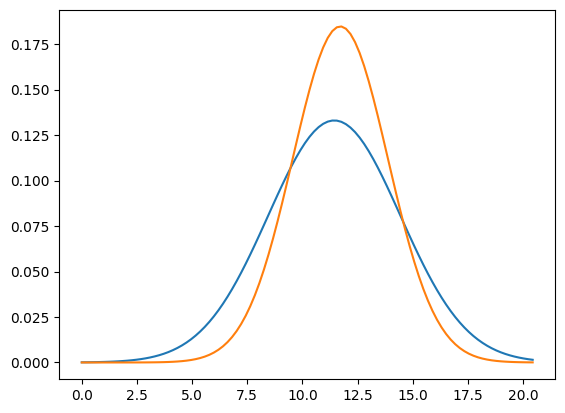

In [18]:
x = np.linspace(0, mu_1 + 3*sigma_1, 100)
plt.plot(x, stats.norm.pdf(x, mu_1, sigma_1))
plt.plot(x, stats.norm.pdf(x, mu_2, sigma_2))
plt.show()